# 7. Benchmark de latencia y comparativo de modelos (baseline vs BETO v3)

En este notebook se documentan tres aspectos del último sprint:

1. Comparativo técnico entre el modelo **baseline**
   (TF-IDF + Regresión Logística) y el modelo **actual** BETO v3 fine-tuned.
2. Informe de **latencia** (p50/p95), **throughput** y errores de inferencia
   del modelo BETO v3, tanto en modo individual como en modo batch.
3. Evidencia en forma de scripts/notebooks de prueba, tablas, figuras
   y logs generados.


Celda 2 – Imports y configuración

In [1]:
import os
import time
import numpy as np
import pandas as pd
import torch

from transformers import AutoTokenizer, AutoModelForSequenceClassification

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedGroupKFold
from sklearn.metrics import f1_score, accuracy_score

import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device


device(type='cuda')

PARTE A · Comparativo baseline vs BETO v3

Celda 3 – Cargar el corpus con folds

In [3]:
# Ajusta la ruta si tu CSV tiene otro nombre o carpeta

PATH_FOLDS = "../data/processed/clean_v2/folds/corpus_clean_v2_folds.csv"

df_full = pd.read_csv(PATH_FOLDS)
df_full.head()


,text,labels,group_id,fold
0,Habla de verdad y solo cuenta su parte,0,3026b3a2a78a2b7c351ce65e1c8a1aea,2
1,La fuerza del pueblo es más fuerte que cualqui...,3,584e534c015f8b6bd23d2d3b57d74283,1
2,Más del 60 % de los empleos creados en pandemi...,2,ba640e8244144484ba43f58ba7b84688,1
3,No hay fuerza más grande que la esperanza,3,deb5caa3e7be895393e0b2e0be670727,0
4,Se llena la boca de patria y vacía los bolsill...,0,261fc2fef1f426ea0a7a90e882286225,2


Celda 4 – Baseline TF-IDF + Regresión Logística

In [6]:
# Detectamos el nombre correcto de la columna de etiquetas
if "label" in df_full.columns:
    label_col = "label"
elif "labels" in df_full.columns:
    label_col = "labels"
else:
    raise ValueError(f"No se encontró columna de etiquetas en df_full. Columnas: {df_full.columns.tolist()}")

print("Usando columna de etiquetas:", label_col)

# Features, labels y grupos
X = df_full["text"].astype(str).tolist()
y = df_full[label_col].values

# Si existe group_id lo usamos como grupo; si no, usamos fold
if "group_id" in df_full.columns:
    groups = df_full["group_id"].values
    print("Usando 'group_id' como columna de grupos.")
else:
    groups = df_full["fold"].values
    print("⚠ No hay 'group_id'; usando 'fold' como grupo mínimo.")

vectorizer = TfidfVectorizer(
    ngram_range=(1, 2),
    max_features=20000,
    min_df=2
)

clf = LogisticRegression(
    max_iter=1000,
    multi_class="multinomial",
    n_jobs=-1
)

cv = StratifiedGroupKFold(n_splits=5, shuffle=True, random_state=42)

baseline_accs = []
baseline_f1s = []

for fold_idx, (train_idx, val_idx) in enumerate(cv.split(X, y, groups), start=1):
    X_train = [X[i] for i in train_idx]
    X_val   = [X[i] for i in val_idx]
    y_train, y_val = y[train_idx], y[val_idx]
    
    X_train_tfidf = vectorizer.fit_transform(X_train)
    X_val_tfidf   = vectorizer.transform(X_val)
    
    clf.fit(X_train_tfidf, y_train)
    y_pred = clf.predict(X_val_tfidf)
    
    acc = accuracy_score(y_val, y_pred)
    f1  = f1_score(y_val, y_pred, average="macro")
    
    baseline_accs.append(acc)
    baseline_f1s.append(f1)
    
    print(f"Fold {fold_idx} - Acc: {acc:.4f} | F1-macro: {f1:.4f}")

baseline_acc_mean = float(np.mean(baseline_accs))
baseline_f1_mean  = float(np.mean(baseline_f1s))

print("\nBaseline (TF-IDF + LR) - Promedio 5 folds")
print(f"Accuracy medio : {baseline_acc_mean:.4f}")
print(f"F1-macro medio : {baseline_f1_mean:.4f}")


Usando columna de etiquetas: labels
Usando 'group_id' como columna de grupos.


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 1 - Acc: 0.9848 | F1-macro: 0.9852


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 2 - Acc: 1.0000 | F1-macro: 1.0000


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 3 - Acc: 0.9596 | F1-macro: 0.9586


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 4 - Acc: 0.9899 | F1-macro: 0.9896


d:\_ JCAM 2010-2028\_3_MASTERAI_UNI\Ciclo4\Tesis 2 Proyecto\ProyectoClasificador\ClasificadorsemanticoBETO\beto_gpu\lib\site-packages\sklearn\linear_model\_logistic.py:1264: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Fold 5 - Acc: 0.9848 | F1-macro: 0.9837

Baseline (TF-IDF + LR) - Promedio 5 folds
Accuracy medio : 0.9838
F1-macro medio : 0.9834


Celda 5 – Comparativo con BETO v3

In [7]:
# Métricas de BETO v3 (desde el notebook 5 / análisis final)
beto_acc_mean = 0.9949
beto_f1_mean  = 0.9950

comparativo_df = pd.DataFrame([
    {
        "modelo": "Baseline (TF-IDF + LR)",
        "accuracy_media": baseline_acc_mean,
        "f1_macro_medio": baseline_f1_mean,
    },
    {
        "modelo": "BETO v3 fine-tuned",
        "accuracy_media": beto_acc_mean,
        "f1_macro_medio": beto_f1_mean,
    },
])

comparativo_df


,modelo,accuracy_media,f1_macro_medio
0,Baseline (TF-IDF + LR),0.983849,0.983427
1,BETO v3 fine-tuned,0.994900,0.995000


Celda 6 – Gráfico comparativo F1

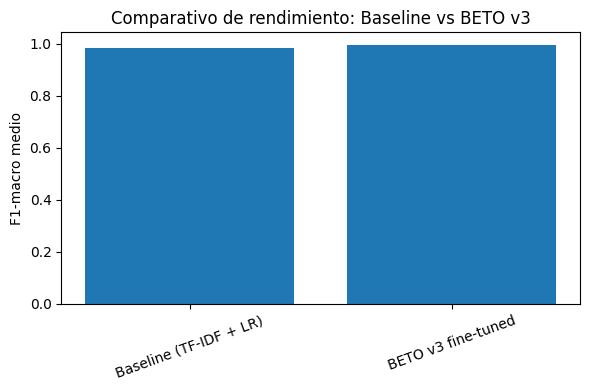

In [8]:
plt.figure(figsize=(6,4))
plt.bar(comparativo_df["modelo"], comparativo_df["f1_macro_medio"])
plt.ylabel("F1-macro medio")
plt.title("Comparativo de rendimiento: Baseline vs BETO v3")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


Celda 7 – Cargar modelo BETO v3

In [9]:
MODEL_DIR = "./models/beto_v3_final_fold0"

tokenizer = AutoTokenizer.from_pretrained(MODEL_DIR)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_DIR)
model.to(device)
model.eval()

print("Modelo cargado desde:", MODEL_DIR)


Modelo cargado desde: ./models/beto_v3_final_fold0


Celda 8 – Función predict_batch

In [10]:
def predict_batch(texts, batch_size=32):
    all_pred_ids = []
    all_probs = []

    for i in range(0, len(texts), batch_size):
        batch_texts = texts[i:i+batch_size]
        enc = tokenizer(
            batch_texts,
            padding=True,
            truncation=True,
            max_length=128,
            return_tensors="pt",
        )
        enc = {k: v.to(device) for k, v in enc.items()}

        with torch.no_grad():
            outputs = model(**enc)
            logits = outputs.logits
            probs = torch.softmax(logits, dim=-1).cpu().numpy()

        pred_ids = np.argmax(probs, axis=1)
        all_pred_ids.extend(pred_ids.tolist())
        all_probs.append(probs)

    all_probs = np.vstack(all_probs)
    return np.array(all_pred_ids), all_probs


Celda 9 – Seleccionar frases para el benchmark

In [12]:
N = 200  # número de frases para medir latencia
texts_bench = df_full["text"].sample(N, random_state=123).tolist()
len(texts_bench), texts_bench[:3]


(200,
 ['[ADVERSARIO] viajan en avión, [PARTIDO] esperamos el bus',
  'Habla de sacrificio y nunca hizo uno',
  'El 35 % de los docentes enseña fuera de su especialidad'])

Celda 10 – Warm-up

In [13]:
_ = predict_batch(texts_bench[:8], batch_size=8)
print("Warm-up completado.")


Warm-up completado.


Celda 11 – Benchmark modo INDIVIDUAL

In [14]:
latencias_individual = []
errores_individual = 0

for txt in texts_bench:
    t0 = time.time()
    try:
        _ = predict_batch([txt], batch_size=1)
    except Exception:
        errores_individual += 1
    t1 = time.time()
    latencias_individual.append(t1 - t0)

lat_ind_ms = np.array(latencias_individual) * 1000

p50_ind = float(np.percentile(lat_ind_ms, 50))
p95_ind = float(np.percentile(lat_ind_ms, 95))
throughput_ind = float(len(texts_bench) / sum(latencias_individual))

print("Modo individual:")
print("  p50 (ms):", round(p50_ind, 1))
print("  p95 (ms):", round(p95_ind, 1))
print("  Throughput (frases/seg):", round(throughput_ind, 2))
print("  Errores durante el benchmark:", errores_individual)


Modo individual:
  p50 (ms): 8.9
  p95 (ms): 13.3
  Throughput (frases/seg): 94.49
  Errores durante el benchmark: 0


Celda 12 – Benchmark modo BATCH

In [15]:
def benchmark_batch(texts, batch_size=16):
    t0 = time.time()
    _ = predict_batch(texts, batch_size=batch_size)
    t1 = time.time()
    return t1 - t0

batch_size = 16
latencias_batch = []
errores_batch = 0

for i in range(0, len(texts_bench), batch_size):
    lote = texts_bench[i:i+batch_size]
    if not lote:
        break
    try:
        dt = benchmark_batch(lote, batch_size=batch_size)
        latencias_batch.append(dt)
    except Exception:
        errores_batch += 1

lat_batch_ms = np.array(latencias_batch) * 1000

p50_batch = float(np.percentile(lat_batch_ms, 50))
p95_batch = float(np.percentile(lat_batch_ms, 95))
throughput_batch = float(len(texts_bench) / sum(latencias_batch))

print(f"Modo batch (batch_size={batch_size}):")
print("  p50 (ms):", round(p50_batch, 1))
print("  p95 (ms):", round(p95_batch, 1))
print("  Throughput (frases/seg):", round(throughput_batch, 2))
print("  Errores durante el benchmark:", errores_batch)


Modo batch (batch_size=16):
  p50 (ms): 17.2
  p95 (ms): 146.4
  Throughput (frases/seg): 370.0
  Errores durante el benchmark: 0


Celda 13 – Tabla resumen + log CSV

In [22]:
resumen_latencia = pd.DataFrame([
    {
        "modo": "individual",
        "batch_size": 1,
        "p50_ms": round(p50_ind, 1),
        "p95_ms": round(p95_ind, 1),
        "throughput_frases_seg": round(throughput_ind, 2),
        "errores": errores_individual,
    },
    {
        "modo": "batch",
        "batch_size": batch_size,
        "p50_ms": round(p50_batch, 1),
        "p95_ms": round(p95_batch, 1),
        "throughput_frases_seg": round(throughput_batch, 2),
        "errores": errores_batch,
    },
])

resumen_latencia


,modo,batch_size,p50_ms,p95_ms,throughput_frases_seg,errores
0,individual,1,8.9,13.3,94.49,0
1,batch,16,17.2,146.4,370.00,0


In [23]:
import os

os.makedirs("logs", exist_ok=True)
log_path = os.path.join("logs", "latencia_beto_v3.csv")
resumen_latencia.to_csv(log_path, index=False)
log_path


'logs\\latencia_beto_v3.csv'

📊 1) Gráfico de Accuracy (baseline vs BETO)

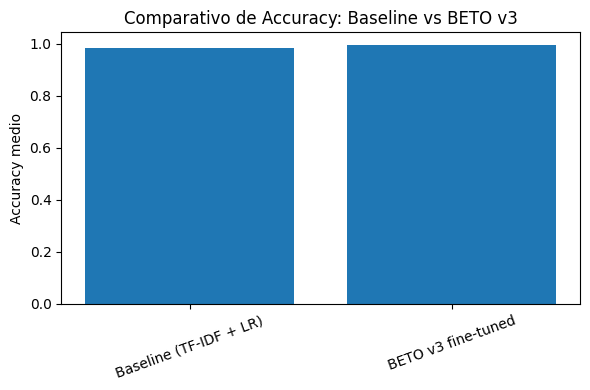

In [24]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
plt.bar(comparativo_df["modelo"], comparativo_df["accuracy_media"])
plt.ylabel("Accuracy medio")
plt.title("Comparativo de Accuracy: Baseline vs BETO v3")
plt.xticks(rotation=20)
plt.tight_layout()
plt.show()


El error del baseline es ≈ 1 − 0.983 ≈ 1,7 %

El error de BETO es ≈ 1 − 0.995 ≈ 0,5 %
Aunque visualmente las barras parecen similares porque ambos modelos están cerca de 1, el baseline se equivoca en torno al 1,7 % de los casos, mientras que BETO baja ese error a aproximadamente 0,5 %. Es decir, reduce el error relativo en alrededor de dos tercios.

📊 2) Gráfico de latencia p50/p95 por modo

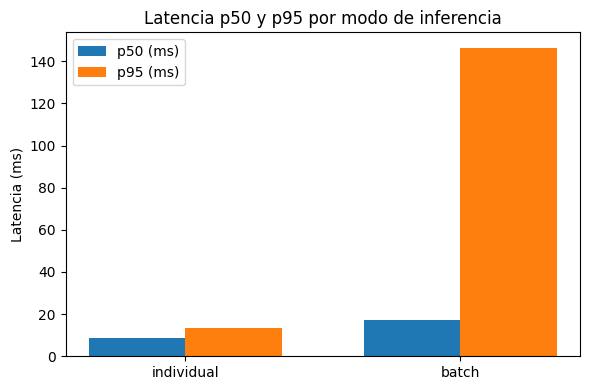

In [25]:
# Gráfico de barras agrupadas: p50 y p95 por modo
modos = resumen_latencia["modo"].tolist()
x = np.arange(len(modos))
ancho = 0.35  # separación entre barras

plt.figure(figsize=(6, 4))
plt.bar(x - ancho/2, resumen_latencia["p50_ms"], width=ancho, label="p50 (ms)")
plt.bar(x + ancho/2, resumen_latencia["p95_ms"], width=ancho, label="p95 (ms)")

plt.xticks(x, modos)
plt.ylabel("Latencia (ms)")
plt.title("Latencia p50 y p95 por modo de inferencia")
plt.legend()
plt.tight_layout()
plt.show()


📊 3) Gráfico de throughput por modo

También con resumen_latencia (throughput_frases_seg).

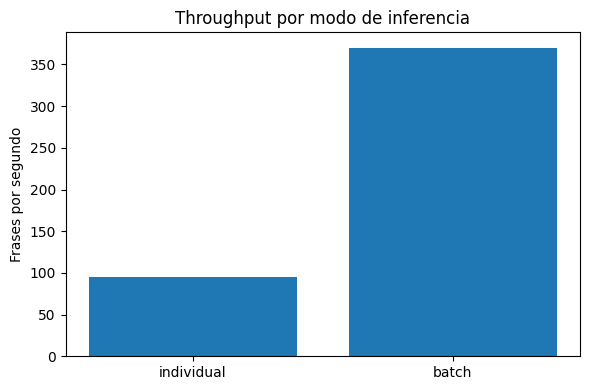

In [26]:
plt.figure(figsize=(6, 4))
plt.bar(resumen_latencia["modo"], resumen_latencia["throughput_frases_seg"])
plt.ylabel("Frases por segundo")
plt.title("Throughput por modo de inferencia")
plt.tight_layout()
plt.show()


Las figuras muestran que el modelo BETO v3 no solo mejora al baseline en F1 y accuracy, sino que además, en términos de ingeniería, mantiene una latencia adecuada y escala bien en throughput cuando se usa en modo batch